In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib.image import imread
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import os
import shutil
import cv2
import glob
import matplotlib.pyplot as plt
import random
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import models
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/dataset/'
!tar --skip-old-files -xf 'cell_images.tar.xz'

/content/drive/MyDrive/dataset
tar: cell_images/train/parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png: Cannot open: Input/output error
tar: Exiting with failure status due to previous errors


In [ ]:
print(len(os.listdir('/content/drive/MyDrive/dataset/cell_images/train/uninfected')))
print(len(os.listdir('/content/drive/MyDrive/dataset/cell_images/train/parasitized')))
print(len(os.listdir('/content/drive/MyDrive/dataset/cell_images/test/uninfected')))
print(len(os.listdir('/content/drive/MyDrive/dataset/cell_images/test/parasitized')))

12479
18176
1300
1300


In [ ]:
train_path = '/content/drive/MyDrive/dataset/cell_images/train'
test_pth = '/content/drive/MyDrive/dataset/cell_images/test'

generator = ImageDataGenerator(validation_split = 0.20,
                               rotation_range = 30,
                               rescale=1/255,
                               shear_range = 0.01,
                               zoom_range = 0.01,
                               horizontal_flip = True)

t_generator = ImageDataGenerator(width_shift_range = 0.1,
                               rotation_range = 30,
                               shear_range = 0.01,
                               zoom_range = 0.01,
                               rescale=1/255,

                               height_shift_range=0.1,
                               horizontal_flip = True)

train_generator = generator.flow_from_directory(
        train_path,
        classes = ['uninfected', 'parasitized'],
        target_size=(224, 224),
        batch_size=32,
        subset = 'training',
        seed = 42,
        class_mode='binary')

val_generator = generator.flow_from_directory(
        train_path,
        classes = ['uninfected', 'parasitized'],
        target_size=(224, 224),
        batch_size=32,
        subset = 'validation',
        class_mode='binary')

test_generator = t_generator.flow_from_directory(
        test_pth,
        classes = ['uninfected', 'parasitized'],
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        shuffle = False)

Found 24525 images belonging to 2 classes.
Found 6130 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [ ]:
my_data_dir = '/content/drive/MyDrive/dataset/cell_images'
os.listdir (my_data_dir)

['test', 'train']

In [ ]:
imgs, labels = next(train_generator)

In [ ]:
def showImages(images_arr, labels):
    fig, axes = plt.subplots(4, 5, figsize=(20,20))
    axes = axes.flatten()
    r = 0
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        label = labels[0 + r]
        if label == 0:
            title = 'Uninfected'
        else:
            title = 'Parasitized'
        ax.set_title(title, fontsize=20)
        r +=1
    plt.tight_layout(pad=0.4, )
    plt.show()

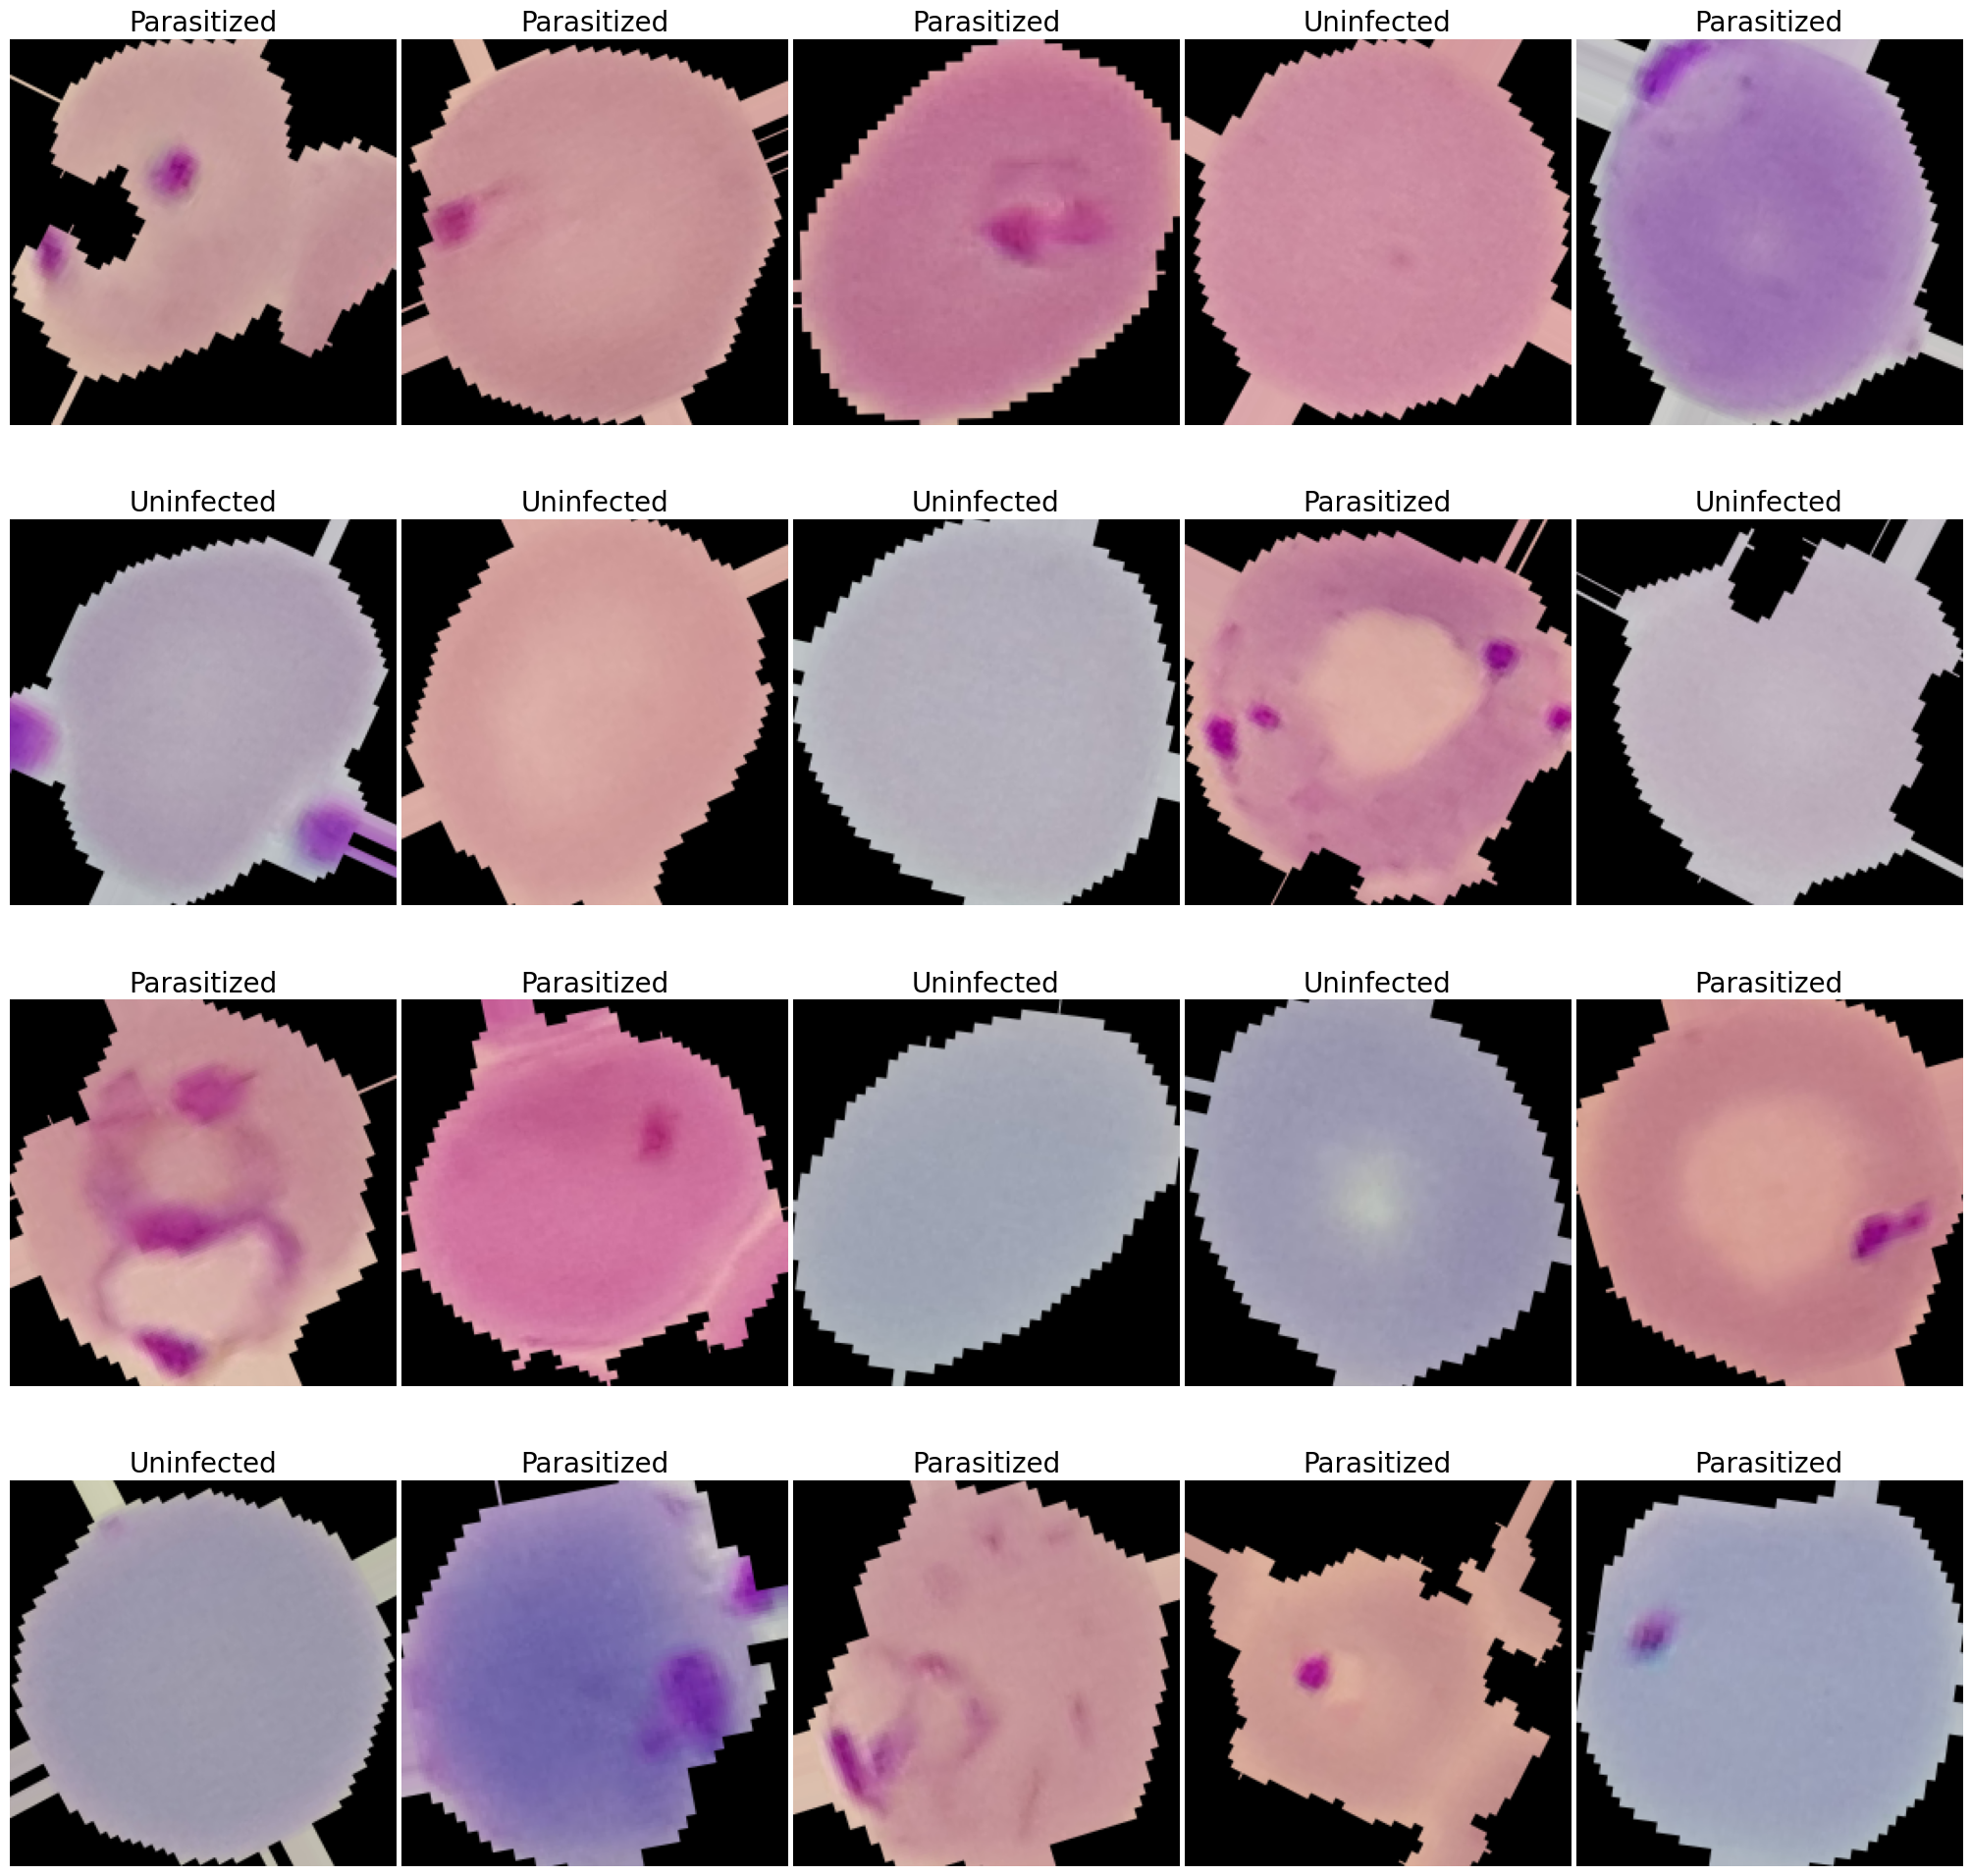

In [ ]:
showImages(imgs, labels)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Load the pre-trained ResNet50 model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model and add the base VGG16 model as a layer
model = Sequential()
model.add(base_model)

# Add additional layers on top of the base model
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()


94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                         

In [ ]:
model.compile(optimizer = Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch= 21856 // 900,
                     epochs=10,
                     verbose=1,
                     batch_size = 16,
                     validation_data = val_generator,
                     validation_steps= 5464 // 900,
                     callbacks = [callback])

Epoch 1/10
24/24 [==============================] - 270s 11s/step - loss: 2.0154 - accuracy: 0.5156 - val_loss: 2.3635 - val_accuracy: 0.6094
Epoch 2/10
24/24 [==============================] - 249s 10s/step - loss: 1.6073 - accuracy: 0.5143 - val_loss: 0.8050 - val_accuracy: 0.6094
Epoch 3/10
24/24 [==============================] - 233s 10s/step - loss: 0.7646 - accuracy: 0.5586 - val_loss: 0.6308 - val_accuracy: 0.6823
Epoch 4/10
24/24 [==============================] - 286s 12s/step - loss: 0.9319 - accuracy: 0.5365 - val_loss: 0.6984 - val_accuracy: 0.5677
Epoch 5/10
24/24 [==============================] - 226s 10s/step - loss: 0.7569 - accuracy: 0.5534 - val_loss: 0.6433 - val_accuracy: 0.6302
Epoch 6/10
24/24 [==============================] - 212s 9s/step - loss: 0.6815 - accuracy: 0.5781 - val_loss: 0.6407 - val_accuracy: 0.6510


In [ ]:
num_steps = len(test_generator)
pred_probabilities = model.predict(test_generator,steps=num_steps, verbose=1)
predictions = pred_probabilities > 0.5
target_names = test_generator.class_indices.keys()
print(classification_report(test_generator.classes, predictions, target_names=target_names))
cm = confusion_matrix(test_generator.classes, predictions)
print("Confusion Matrix:")
print(cm)

130/130 [==============================] - 560s 4s/step
              precision    recall  f1-score   support

  uninfected       0.59      0.68      0.63      1300
 parasitized       0.62      0.52      0.56      1300

    accuracy                           0.60      2600
   macro avg       0.60      0.60      0.60      2600
weighted avg       0.60      0.60      0.60      2600

Confusion Matrix:
[[888 412]
 [627 673]]


1/1 [==============================] - 1s 823ms/step


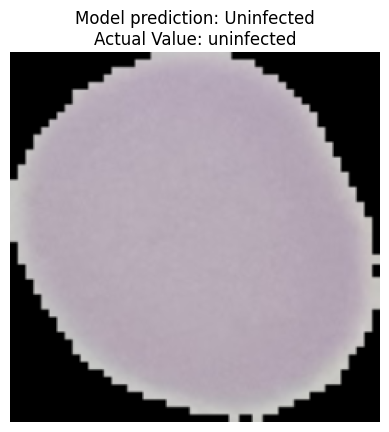

In [ ]:
import random
list_dir=["uninfected", "parasitized"]
dir_=(random.choice(list_dir))
para_img= imread(train_path+
                 '/'+dir_+'/'+
                 os.listdir(train_path+'/'+dir_)[random.randint(0, 10000)])
img = tf.convert_to_tensor (np.asarray(para_img))
img = tf.image.resize(img, (224,224))
img=img.numpy()
pred=bool(model.predict(img.reshape(1,224,224,3))<0.5)
plt.title("Model prediction: "+("Uninfected" if pred else "Parasitized") + "\nActual Value: "+str(dir_))
plt.axis("off")
plt.imshow(img)